### Deskripsi Singkat Dataset:

tulis deskripsi singkat dataset yang Anda gunakan

---

### Dataset yang diambil dari repositori:

COVID Face Mask Detection Dataset – sumber : https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

### Hasil kerja

In [75]:
import argparse
import cv2
import math, time, random, datetime
import os
import numpy as np
from matplotlib import pyplot as plt
# import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import imutils
import warnings

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps



warnings.filterwarnings('ignore')

Path untuk folder data

In [20]:
TRAIN_PATH  = './kaggle/Train' #Mengandung 90% dari dataset
TEST_PATH  = './kaggle/Test' # Mengandung 10% dari dataset

IMG_SIZE = 224

### PREPROCESSING

Memberi Label pada gambar serta membagi dataset menjadi training dan validation.
PREPROCESSING: 
1. LABELLING DATA
2. MEMISAHKAN DATA (berdasarkan random seed: 123)
3. RESIZE IMAGE (menggunakan billinear interpolation)
4. COLOR MODE : GRAYSCALE

In [21]:
print("TRAINING + VALIDATION")

seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)
print("TESTING")
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)

TRAINING + VALIDATION
Found 906 files belonging to 2 classes.
Using 725 files for training.
Found 906 files belonging to 2 classes.
Using 181 files for validation.
TESTING
Found 100 files belonging to 2 classes.


Menyetelkan buffered prefetching untuk mengurangi pengambilan gambar dari disk.

Menunjukkan 9 data pertama dari dataset Training.

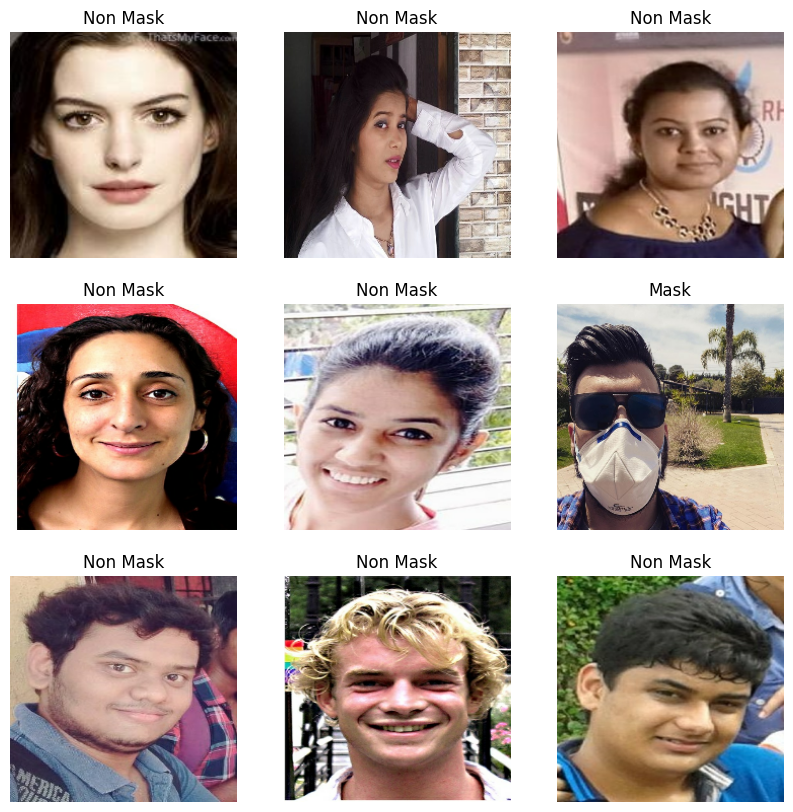

In [22]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Rescale pixel dari 0-255 menjadi 0-1.

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Membuat Model menggunakan MobileNetV2 sebagai Base model.

In [25]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Include false agar dapat menggantikan top layer dari model dengan layer khusus kita nanti
                                               weights='imagenet')

Jika telah inisialisasi model, maka memasukin training model.

Sebelum model dilatih, base_model trainable dimatikan dulu. Kita ingin mematikan layer-layer bawah dari model agar tidak menggantikan bobot yang membuatnya mengenal objek.

Layer convolution pada lapisan pertama base_model akan berfungsi sebagai feature extractor.

In [26]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Feature Extraction dalam MobileNetV2 akan mengubah data pixel kita menjadi 7x7x1280 (karena filter yang telah digunakan pada convolution layernya).

In [27]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
feature_batch.numpy()[1]

(32, 7, 7, 1280)


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01261806],
        [0.        , 0.56260014, 0.        , ..., 0.        ,
         0.        , 3.4367485 ],
        [0.        , 1.5651584 , 0.        , ..., 0.        ,
         0.        , 2.7699437 ],
        ...,
        [0.        , 1.9636235 , 0.        , ..., 0.        ,
         0.        , 0.00835085],
        [0.        , 1.4856234 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 2.4746227 ],
        [0.        , 2.7396502 , 0.        , ..., 0.        ,
         0.        , 4.6623907 ],
        [0.        , 0.9398961 , 0.        , ..., 1.2625012 ,
         0.        , 2.2916603 ],
        ...,
        [0.        , 2.6871886 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

Kita akan menggunakan Global Average Pooling 2D layer untuk mengubah vector yang didapati dari base_model menjadi 1280 vector.

Setelah mendapatkan vector tersebut membuat klasifikasi dilakukan menggunakan Dense Layer.

In [28]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dimasukkan Dropout untuk menghindari overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
# CARA SEBELUMNYA
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(1)
# stacked_layers = [global_average_layer, prediction_layer]
# model = tf.keras.Sequential([base_model] + stacked_layers)

Menetapkan base_learning_rate dan membuat membuat model.

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
            

Rangkaian Model Terkahir:

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

### Melatih dan membuat evaluasi
Jika tanpa training hasil yang diberikan adalah:

In [32]:
validation_steps = 6
initial_epochs = 15

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

6/6 [==============================] - 7s 378ms/step - loss: 0.6236 - accuracy: 0.6961


Dapa dilihat, model hanya 0.6077 akurat dalam mendeteksi wajah bermasker. Hal ini tidak bagus karena, jika model menebak maka hasilnya 0.5. Jadi meskipun memiliki bobot dari ImageNet dan architecure MobileNetV2 (transfer learning), model hanya  bisa menentukan wajah bermasker sedikit lebih baik dari penebakan.

Melatih model (layer teratas)

In [33]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
23/23 [==============================] - 16s 563ms/step - loss: 0.5713 - accuracy: 0.6993 - val_loss: 0.5020 - val_accuracy: 0.7901
Epoch 2/15
23/23 [==============================] - 13s 544ms/step - loss: 0.4906 - accuracy: 0.7669 - val_loss: 0.4359 - val_accuracy: 0.8398
Epoch 3/15
23/23 [==============================] - 13s 536ms/step - loss: 0.4228 - accuracy: 0.8207 - val_loss: 0.3834 - val_accuracy: 0.8729
Epoch 4/15
23/23 [==============================] - 14s 580ms/step - loss: 0.3784 - accuracy: 0.8345 - val_loss: 0.3416 - val_accuracy: 0.9171
Epoch 5/15
23/23 [==============================] - 13s 541ms/step - loss: 0.3349 - accuracy: 0.8897 - val_loss: 0.3003 - val_accuracy: 0.9116
Epoch 6/15
23/23 [==============================] - 13s 539ms/step - loss: 0.2933 - accuracy: 0.8910 - val_loss: 0.2673 - val_accuracy: 0.9282
Epoch 7/15
23/23 [==============================] - 13s 573ms/step - loss: 0.2544 - accuracy: 0.9269 - val_loss: 0.2377 - val_accuracy: 0.9448

History dari Training dan Fitting

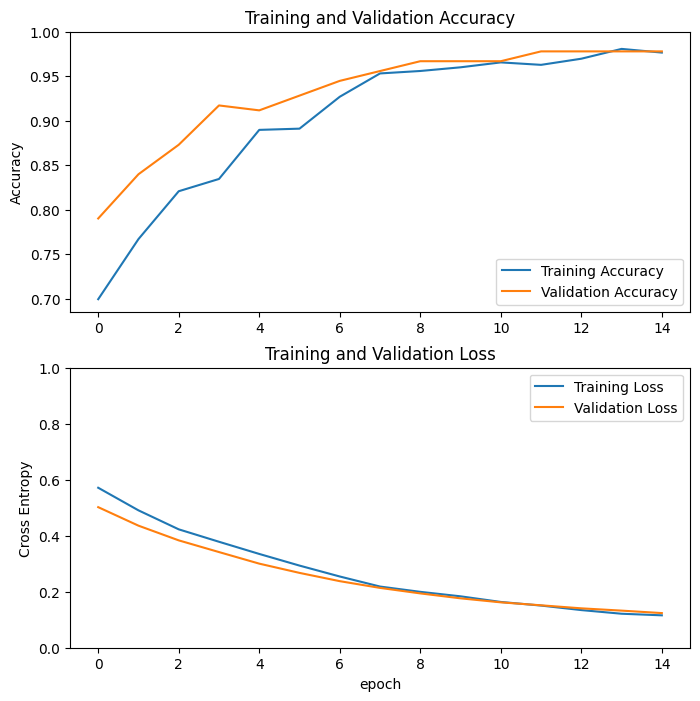

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluasi dengan Testing

In [35]:
testing_steps = 4
loss1,accuracy1 = model.evaluate(test_ds, steps = testing_steps)

4/4 [==============================] - 3s 300ms/step - loss: 0.0973 - accuracy: 1.0000


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

Fine-tuning model saat epoch = 50

In [37]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [38]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [39]:
# Kita turunin base_learning supaya tidak terlalu mengbuhah seluruh bobot (dengan trainable paramter yang lebih besar) dengan pesat sehingga overfitting  
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), 
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [40]:
model.evaluate(test_ds, steps=4)

4/4 [==============================] - 3s 356ms/step - loss: 0.0973 - accuracy: 1.0000


[0.0973043143749237, 1.0]

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [42]:
len(model.trainable_variables)

56

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch= initial_epochs, validation_data = val_ds)


Epoch 16/25
23/23 [==============================] - 25s 809ms/step - loss: 0.0580 - accuracy: 0.9821 - val_loss: 0.0490 - val_accuracy: 0.9779
Epoch 17/25
23/23 [==============================] - 18s 766ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.0345 - val_accuracy: 0.9779
Epoch 18/25
23/23 [==============================] - 18s 751ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 0.0368 - val_accuracy: 0.9779
Epoch 19/25
23/23 [==============================] - 19s 789ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.0284 - val_accuracy: 0.9779
Epoch 20/25
23/23 [==============================] - 18s 783ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9834
Epoch 21/25
23/23 [==============================] - 19s 794ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9834
Epoch 22/25
23/23 [==============================] - 18s 769ms/step - loss: 4.5645e-04 - accuracy: 1.0000 - val_loss: 0.0248 - val_accur

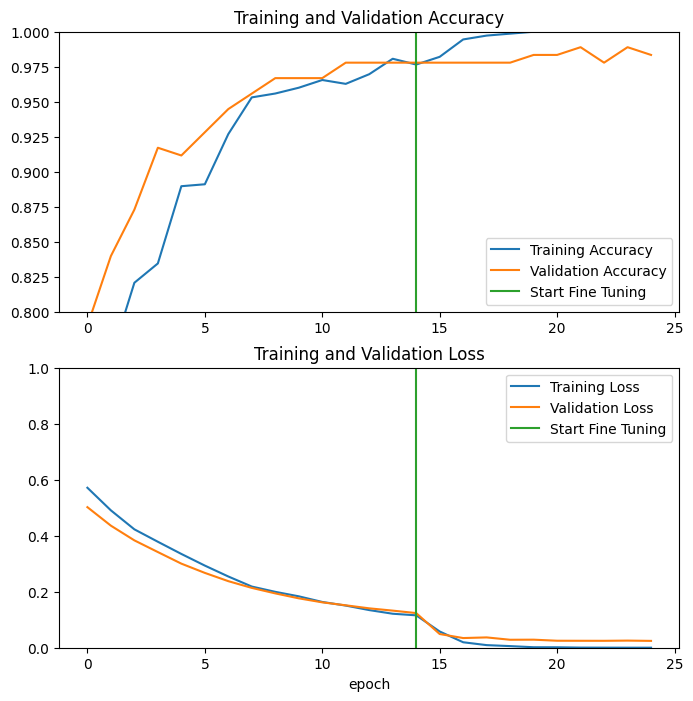

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Final Evaluation

In [27]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 310ms/step - loss: 6.3746e-05 - accuracy: 1.0000
Test accuracy : 1.0


# Membuat Classifier mengenal beberapa object dalam sebuah gambar

Ambil dua gambar

In [15]:
mask_image = cv2.imread('./kaggle/Test/Mask/2086.jpg')
non_mask_image = cv2.imread('./kaggle/Test/Non Mask/real_01040.jpg')

In [16]:
type(non_mask_image)

numpy.ndarray

In [17]:
type(mask_image)

numpy.ndarray

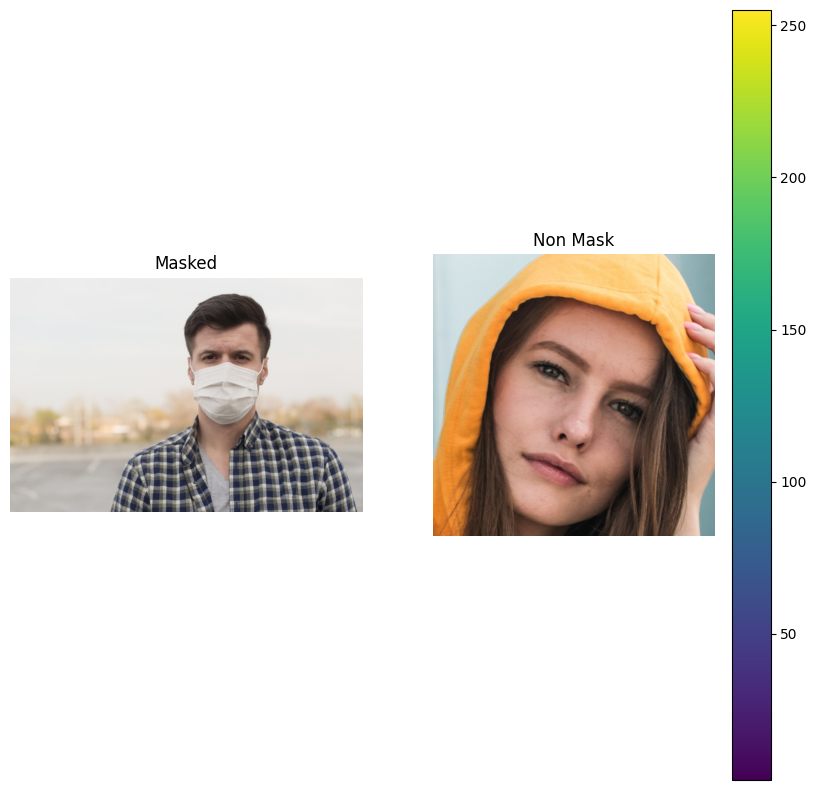

In [45]:
mask_image = cv2.imread('./images/2086.jpg')
non_mask_image = cv2.imread('./images/real_01040.jpg')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
non_mask_image = cv2.cvtColor(non_mask_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize = (10,10))
images = ("Masked", mask_image), ("Non Mask", non_mask_image)
# loop over the images
for (i, (name, image)) in enumerate(images):
    # show the image
    ax = fig.add_subplot(1, 2, i + 1)
    ax.set_title(name)
    plt.imshow(image)
    plt.axis("off")
plt.colorbar()

In [48]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "./images/2086.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

In [59]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w) 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [62]:
WIDTH = 600 # 
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) # input of Mobile Net model.summary()

In [63]:
image.shape

(417, 626, 3)

In [66]:
orig = image
orig = imutils.resize(orig, width = WIDTH)
(H, W) = orig.shape[:2] # 417, 626

In [67]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid 
#and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()
counter = 0
tot_images = 0
for p, image in enumerate(pyramid):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = tf.keras.preprocessing.image.img_to_array(roi)
        roi = tf.keras.applications.resnet.preprocess_input(roi)
        #print(roiOrig.shape, roi.shape)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
            # show the visualization and current ROI
            #plt.imshow(clone)
            #var_name = "p" + str(p)+"_" + "sw" + str(sw) + ".jpg"
            #plt.savefig("images/clone_"+ var_name)
            #plt.imshow(roiOrig)
            #plt.savefig("images/roiOrig_"+ var_name)
            #cv2.waitKey(0)
            tot_images = tot_images +1
print(roiOrig.shape, roi.shape)
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

(150, 200, 3) (224, 224, 3)
[INFO] looping over pyramid/windows took 0.04980 seconds
Total images 71.00


In [96]:
model.predict(roi)

InvalidArgumentError: Graph execution error:

Detected at node 'model/mobilenetv2_1.00_224/Conv1_relu/Relu6' defined at (most recent call last):
    File "c:\Users\user\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\user\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\user\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_34264\2155512243.py", line 1, in <module>
      model.predict(roi)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\layers\activation\relu.py", line 105, in call
      return backend.relu(
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5363, in relu
      x = tf.nn.relu6(x)
Node: 'model/mobilenetv2_1.00_224/Conv1_relu/Relu6'
input must be 4-dimensional[32,224,3]
	 [[{{node model/mobilenetv2_1.00_224/Conv1_relu/Relu6}}]] [Op:__inference_predict_function_27203]

In [68]:
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
my_preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
3/3 [==============================] - 2s 219ms/step
[INFO] classifying ROIs took 1.67287 seconds


ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 626, 3)


In [71]:
preds = tf.keras.applications.mobilenet_v2.decode_predictions(my_preds, top=1)
preds[30:35]

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (71, 1)

In [78]:
# Function to Display Image
def display_image(image,file):
    fig = plt.figure(figsize=(15, 10))
    plt.grid(False)
    plt.imshow(image)
    plt.title(file, fontsize=20)

    
# Function to Resize Image
def resize_image(img, new_width=300, new_height=300,display=False):
    img_path = os.path.join(random_images,img)
    pil_image = Image.open(img_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    if display:
        display_image(pil_image, img)

In [79]:
#  Random Images Directory Path
random_images = './images/'

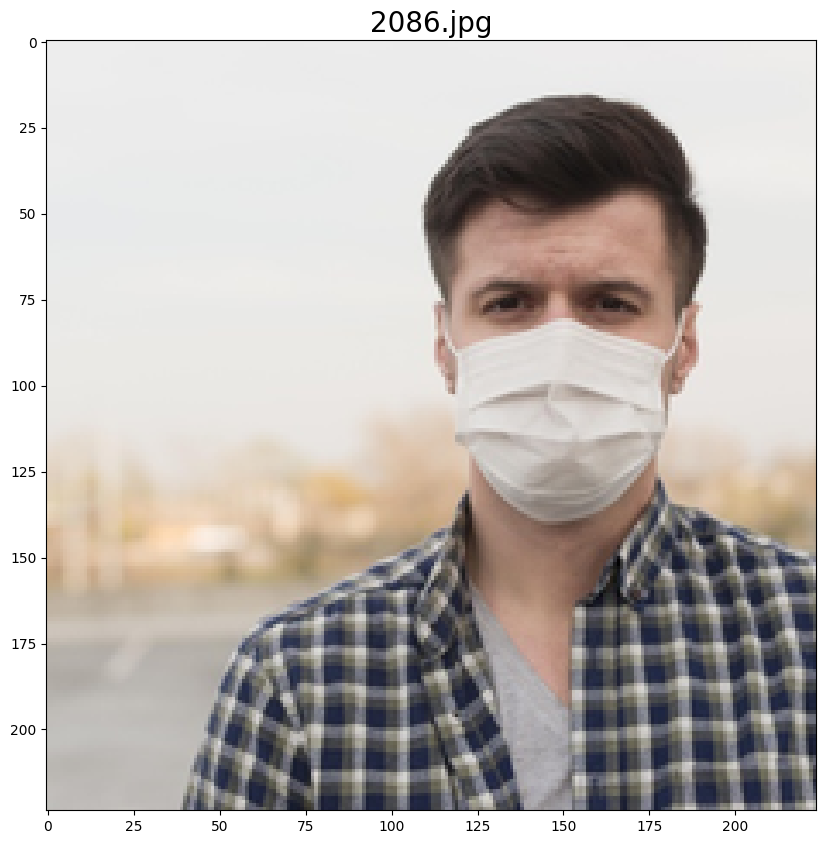

In [81]:
# Applying the Function 
resize_image(random.choice(os.listdir(random_images)),224,224,True)

In [82]:
# Function to Draw Bounding Boxes on Image
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness=4,display_str_list=()):
       
    # Adds a bounding box to an image.
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,fill=color)
    
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),(left + text_width, text_bottom)],fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin
        

# Function to Draw Boxes       
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):
    
    # Overlay labeled boxes on an image with formatted scores and label names.
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [83]:
# Function to Load Image from Random Image Folder using TensorFlow
def load_img(img_file):
    path = os.path.join(random_images,img_file)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [89]:
# Function to Detect Object using TensorFlow's Pretrained Model
def detect(model, img_file):
    
    img = load_img(img_file)
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    start_time = time.time()   # Start Timer
    
    result = model.predict(converted_img)   # Detection Using Pretrained Model downloaded above
    
    end_time = time.time()    # End Timer
    
    result = {key:value.numpy() for key,value in result.items()}
    
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time (secs): ",'{:.2}'.format(end_time-start_time))
    
    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"])
    
    display_image(image_with_boxes,img_file)

In [90]:
detect(model,  random.choice(os.listdir(random_images)))

1/1 [==============================] - 1s 945ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [91]:
model.predict(image)

ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 266, 3)


AttributeError: 'Functional' object has no attribute 'add'